In [1]:

import glob
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd

import itertools
from itertools import cycle
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import imageio
from sklearn.preprocessing import label_binarize
from collections import Counter

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split, KFold
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime
from tensorflow.keras.callbacks import EarlyStopping

2023-09-25 12:05:37.657563: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 12:05:37.933003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 12:05:39.962884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 12:05:39.969425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 12:05:44.771523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
label_data  = pd.read_csv("/home/muhlabws4/Belgeler/UFC101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt",
                       sep = " ",
                       header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()



,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [3]:
path=[]
for label in label_data.labels.values:
    path.append('/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/'+label+"/")
path[0]

'/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/ApplyEyeMakeup/'

In [4]:
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    video_reader = cv2.VideoCapture(video_path)
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count/sequence_length), 1)
    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break;
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        frames_list.append(frame)
    video_reader.release()
    return frames_list

In [5]:
import sys
import platform

print(platform.python_version())


3.11.4


In [6]:

import cv2
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

images, labels = load_video(path[81:])
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)

100%|█████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.30it/s]


In [6]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
images = np.load('images.npy')
labels = np.load('labels.npy')

In [7]:
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((2371, 5, 60, 60, 3), (152, 5, 60, 60, 3), (2371,), (152,))

In [8]:
def videoview(index):
    fig = plt.figure(figsize=(32,8))
    for i,image in enumerate(images[index]):
        ax = plt.subplot(1,5,i+1)
        imshow(image[:,:,0])
        plt.title(label_data.labels.values[labels[index]+81],fontsize=21)

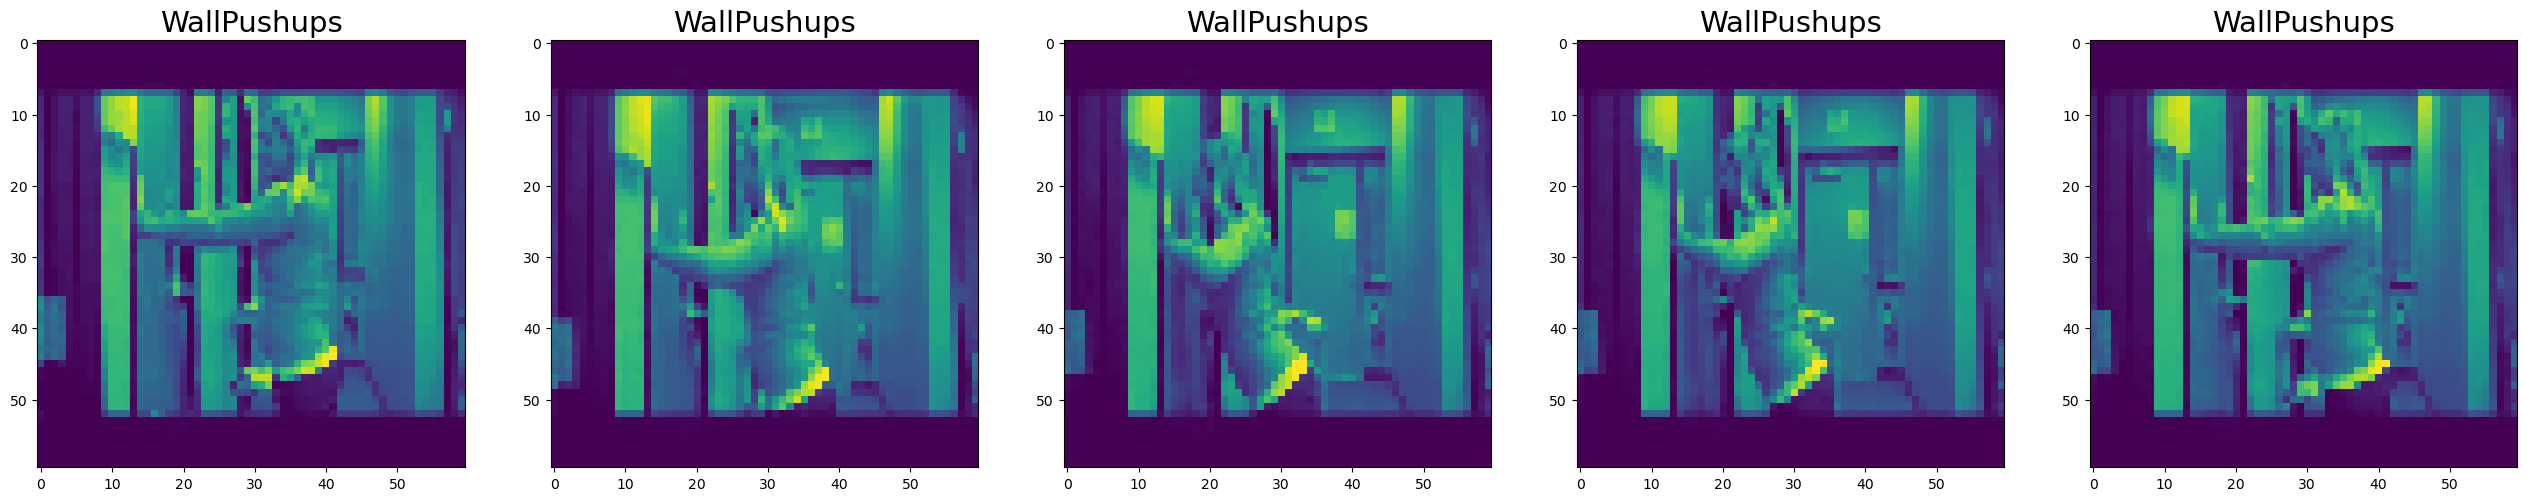

In [9]:
random_video_index = np.random.randint(0,len(images))
videoview(random_video_index)

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [11]:
num_frames = 5  # Çerçeve sayısı
frame_height = 60  # Çerçeve yüksekliği
frame_width = 60   # Çerçeve genişliği
num_channels = 3   # Kanal sayısı
num_classes = 20 

In [13]:
# Model oluşturma
model = Sequential()

# CNN katmanları
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(num_frames, frame_height, frame_width, num_channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# LSTM katmanları
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))  # Son LSTM katmanı return_sequences=False ile sona erer

# Tam bağlantılı (Dense) katmanlar
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))  # 20 sınıf için çıkış katmanı

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model özetini görüntüle
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDi  (None, 5, 58, 58, 32)     896       
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 5, 29, 29, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 5, 27, 27, 64)     18496     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 5, 13, 13, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 5, 11, 11, 128)   

In [14]:
class_weight = Counter(y_train)
class_weight

Counter({11: 124,
         6: 118,
         5: 111,
         18: 147,
         2: 139,
         7: 122,
         4: 109,
         1: 105,
         16: 114,
         14: 94,
         17: 126,
         8: 136,
         13: 125,
         9: 90,
         10: 154,
         19: 117,
         12: 110,
         15: 109,
         3: 130,
         0: 91})

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
model.fit(x_train, y_train, epochs=25)

Epoch 1/25
75/75 [==============================] - 6s 51ms/step - loss: 2.9467 - accuracy: 0.0894
Epoch 2/25
75/75 [==============================] - 4s 50ms/step - loss: 2.5215 - accuracy: 0.2046
Epoch 3/25
75/75 [==============================] - 4s 50ms/step - loss: 2.1237 - accuracy: 0.3264
Epoch 4/25
75/75 [==============================] - 4s 50ms/step - loss: 1.8944 - accuracy: 0.4015
Epoch 5/25
75/75 [==============================] - 4s 50ms/step - loss: 1.4822 - accuracy: 0.5441
Epoch 6/25
75/75 [==============================] - 4s 51ms/step - loss: 1.1643 - accuracy: 0.6390
Epoch 7/25
75/75 [==============================] - 4s 50ms/step - loss: 0.8562 - accuracy: 0.7410
Epoch 8/25
75/75 [==============================] - 4s 51ms/step - loss: 0.6179 - accuracy: 0.8111
Epoch 9/25
75/75 [==============================] - 4s 51ms/step - loss: 0.5321 - accuracy: 0.8423
Epoch 10/25
75/75 [==============================] - 4s 50ms/step - loss: 0.3482 - accuracy: 0.8996
Epoch 11/

In [17]:
print(model.evaluate(x_test, y_test))

5/5 [==============================] - 1s 24ms/step - loss: 0.4299 - accuracy: 0.8947
[0.42994409799575806, 0.8947368264198303]


In [18]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

5/5 [==============================] - 1s 20ms/step


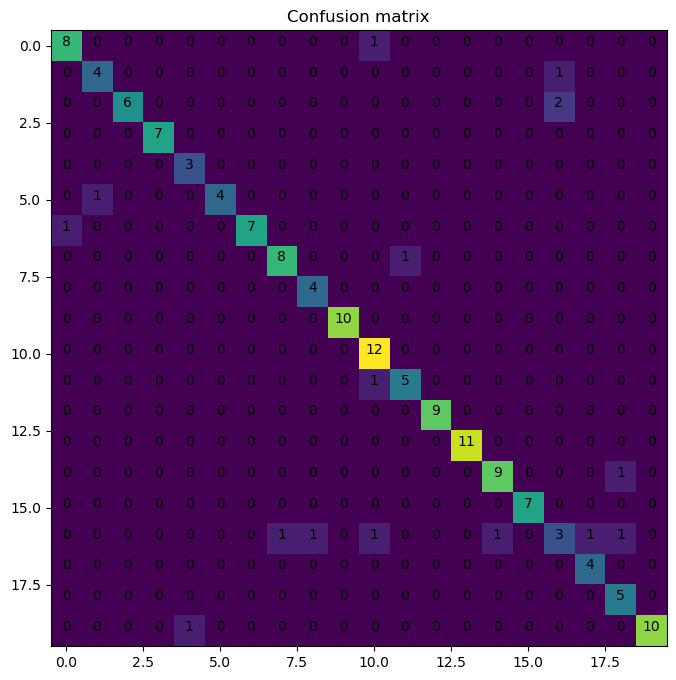

In [22]:
plt.figure(figsize=(8,8))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [28]:
from sklearn.model_selection import StratifiedKFold
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(num_frames, frame_height, frame_width, num_channels)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax')) 
    return model

fold_number = 1
for train_index, test_index in skf.split(x_train, y_train):
    X_train, X_test = x_train[train_index], x_train[test_index]
    y_trainn, y_testt = y_train[train_index], y_train[test_index]

    model = create_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f"Training for Fold {fold_number}...")
    model.fit(X_train, y_trainn, epochs=15, verbose=2)
    model.save(f'my_model_{fold_number}.h5')
    tf.keras.models.save_model(model, f'my_model_{fold_number}')
    print(f"Evaluating for Fold {fold_number}...")
    loss, accuracy = model.evaluate(X_test, y_testt, verbose=2)
    print(f"Fold {fold_number} - Loss: {loss}, Accuracy: {accuracy}")

    fold_number += 1

Training for Fold 1...
Epoch 1/15
60/60 - 5s - loss: 2.9466 - accuracy: 0.0770 - 5s/epoch - 84ms/step
Epoch 2/15
60/60 - 3s - loss: 2.6949 - accuracy: 0.1603 - 3s/epoch - 49ms/step
Epoch 3/15
60/60 - 3s - loss: 2.3268 - accuracy: 0.2674 - 3s/epoch - 49ms/step
Epoch 4/15
60/60 - 3s - loss: 2.0816 - accuracy: 0.3386 - 3s/epoch - 49ms/step
Epoch 5/15
60/60 - 3s - loss: 1.8199 - accuracy: 0.4293 - 3s/epoch - 49ms/step
Epoch 6/15
60/60 - 3s - loss: 1.5648 - accuracy: 0.4947 - 3s/epoch - 49ms/step
Epoch 7/15
60/60 - 3s - loss: 1.2658 - accuracy: 0.6155 - 3s/epoch - 49ms/step
Epoch 8/15
60/60 - 3s - loss: 1.0998 - accuracy: 0.6503 - 3s/epoch - 49ms/step
Epoch 9/15
60/60 - 3s - loss: 0.7873 - accuracy: 0.7600 - 3s/epoch - 49ms/step
Epoch 10/15
60/60 - 3s - loss: 0.6327 - accuracy: 0.8085 - 3s/epoch - 48ms/step
Epoch 11/15
60/60 - 3s - loss: 0.5039 - accuracy: 0.8460 - 3s/epoch - 49ms/step
Epoch 12/15
60/60 - 3s - loss: 0.3473 - accuracy: 0.8935 - 3s/epoch - 50ms/step
Epoch 13/15
60/60 - 3s - l

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: my_model_1/assets


INFO:tensorflow:Assets written to: my_model_1/assets


Evaluating for Fold 1...
15/15 - 1s - loss: 1.0250 - accuracy: 0.7579 - 715ms/epoch - 48ms/step
Fold 1 - Loss: 1.0250277519226074, Accuracy: 0.75789475440979
Training for Fold 2...
Epoch 1/15
60/60 - 5s - loss: 2.9440 - accuracy: 0.0706 - 5s/epoch - 84ms/step
Epoch 2/15
60/60 - 3s - loss: 2.6204 - accuracy: 0.1856 - 3s/epoch - 48ms/step
Epoch 3/15
60/60 - 3s - loss: 2.2793 - accuracy: 0.2905 - 3s/epoch - 48ms/step
Epoch 4/15
60/60 - 3s - loss: 2.0778 - accuracy: 0.3379 - 3s/epoch - 49ms/step
Epoch 5/15
60/60 - 3s - loss: 1.8385 - accuracy: 0.4101 - 3s/epoch - 48ms/step
Epoch 6/15
60/60 - 3s - loss: 1.5842 - accuracy: 0.4918 - 3s/epoch - 48ms/step
Epoch 7/15
60/60 - 3s - loss: 1.3000 - accuracy: 0.5946 - 3s/epoch - 48ms/step
Epoch 8/15
60/60 - 3s - loss: 1.1649 - accuracy: 0.6231 - 3s/epoch - 49ms/step
Epoch 9/15
60/60 - 3s - loss: 0.9299 - accuracy: 0.7138 - 3s/epoch - 48ms/step
Epoch 10/15
60/60 - 3s - loss: 0.6907 - accuracy: 0.7955 - 3s/epoch - 49ms/step
Epoch 11/15
60/60 - 3s - los

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: my_model_2/assets


INFO:tensorflow:Assets written to: my_model_2/assets


Evaluating for Fold 2...
15/15 - 1s - loss: 0.7050 - accuracy: 0.8270 - 730ms/epoch - 49ms/step
Fold 2 - Loss: 0.7049931287765503, Accuracy: 0.8270041942596436
Training for Fold 3...
Epoch 1/15
60/60 - 5s - loss: 2.9209 - accuracy: 0.0875 - 5s/epoch - 91ms/step
Epoch 2/15
60/60 - 3s - loss: 2.6496 - accuracy: 0.1676 - 3s/epoch - 48ms/step
Epoch 3/15
60/60 - 3s - loss: 2.3112 - accuracy: 0.2620 - 3s/epoch - 50ms/step
Epoch 4/15
60/60 - 3s - loss: 2.0459 - accuracy: 0.3463 - 3s/epoch - 48ms/step
Epoch 5/15
60/60 - 3s - loss: 1.8716 - accuracy: 0.4233 - 3s/epoch - 50ms/step
Epoch 6/15
60/60 - 3s - loss: 1.5785 - accuracy: 0.4997 - 3s/epoch - 49ms/step
Epoch 7/15
60/60 - 3s - loss: 1.3004 - accuracy: 0.5830 - 3s/epoch - 49ms/step
Epoch 8/15
60/60 - 3s - loss: 1.0618 - accuracy: 0.6784 - 3s/epoch - 48ms/step
Epoch 9/15
60/60 - 3s - loss: 0.8097 - accuracy: 0.7586 - 3s/epoch - 49ms/step
Epoch 10/15
60/60 - 3s - loss: 0.6176 - accuracy: 0.8113 - 3s/epoch - 50ms/step
Epoch 11/15
60/60 - 3s - l

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: my_model_3/assets


INFO:tensorflow:Assets written to: my_model_3/assets


Evaluating for Fold 3...
15/15 - 1s - loss: 0.6428 - accuracy: 0.8376 - 723ms/epoch - 48ms/step
Fold 3 - Loss: 0.6427776217460632, Accuracy: 0.8375527262687683
Training for Fold 4...
Epoch 1/15
60/60 - 5s - loss: 2.9808 - accuracy: 0.0627 - 5s/epoch - 91ms/step
Epoch 2/15
60/60 - 3s - loss: 2.6934 - accuracy: 0.1703 - 3s/epoch - 49ms/step
Epoch 3/15
60/60 - 3s - loss: 2.3176 - accuracy: 0.2783 - 3s/epoch - 49ms/step
Epoch 4/15
60/60 - 3s - loss: 2.0277 - accuracy: 0.3521 - 3s/epoch - 49ms/step
Epoch 5/15
60/60 - 3s - loss: 1.7286 - accuracy: 0.4449 - 3s/epoch - 49ms/step
Epoch 6/15
60/60 - 3s - loss: 1.3998 - accuracy: 0.5535 - 3s/epoch - 50ms/step
Epoch 7/15
60/60 - 3s - loss: 1.2186 - accuracy: 0.6089 - 3s/epoch - 49ms/step
Epoch 8/15
60/60 - 3s - loss: 0.9051 - accuracy: 0.7327 - 3s/epoch - 49ms/step
Epoch 9/15
60/60 - 3s - loss: 0.7007 - accuracy: 0.7939 - 3s/epoch - 48ms/step
Epoch 10/15
60/60 - 3s - loss: 0.5670 - accuracy: 0.8366 - 3s/epoch - 49ms/step
Epoch 11/15
60/60 - 3s - l

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: my_model_4/assets


INFO:tensorflow:Assets written to: my_model_4/assets


Evaluating for Fold 4...
15/15 - 1s - loss: 0.8965 - accuracy: 0.8017 - 731ms/epoch - 49ms/step
Fold 4 - Loss: 0.896516740322113, Accuracy: 0.8016877770423889
Training for Fold 5...
Epoch 1/15
60/60 - 5s - loss: 2.9753 - accuracy: 0.0801 - 5s/epoch - 84ms/step
Epoch 2/15
60/60 - 3s - loss: 2.6640 - accuracy: 0.1776 - 3s/epoch - 48ms/step
Epoch 3/15
60/60 - 3s - loss: 2.3085 - accuracy: 0.2841 - 3s/epoch - 49ms/step
Epoch 4/15
60/60 - 3s - loss: 2.0772 - accuracy: 0.3574 - 3s/epoch - 49ms/step
Epoch 5/15
60/60 - 3s - loss: 1.8133 - accuracy: 0.4396 - 3s/epoch - 50ms/step
Epoch 6/15
60/60 - 3s - loss: 1.5422 - accuracy: 0.5277 - 3s/epoch - 49ms/step
Epoch 7/15
60/60 - 3s - loss: 1.2799 - accuracy: 0.6173 - 3s/epoch - 48ms/step
Epoch 8/15
60/60 - 3s - loss: 0.9989 - accuracy: 0.7090 - 3s/epoch - 49ms/step
Epoch 9/15
60/60 - 3s - loss: 0.8683 - accuracy: 0.7396 - 3s/epoch - 48ms/step
Epoch 10/15
60/60 - 3s - loss: 0.6111 - accuracy: 0.8202 - 3s/epoch - 49ms/step
Epoch 11/15
60/60 - 3s - lo

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: my_model_5/assets


INFO:tensorflow:Assets written to: my_model_5/assets


Evaluating for Fold 5...
15/15 - 1s - loss: 0.6318 - accuracy: 0.8249 - 741ms/epoch - 49ms/step
Fold 5 - Loss: 0.6317644119262695, Accuracy: 0.8248944878578186


In [16]:
from keras.models import load_model

model1 = load_model('my_model_1/my_model_1.h5')
model1 = tf.keras.models.load_model('my_model_1')

model2 = load_model('my_model_2/my_model_2.h5')
model2 = tf.keras.models.load_model('my_model_2')

model3 = load_model('my_model_3/my_model_3.h5')
model3 = tf.keras.models.load_model('my_model_3')

model4 = load_model('my_model_4/my_model_4.h5')
model4 = tf.keras.models.load_model('my_model_4')

model5 = load_model('my_model_5/my_model_5.h5')
model5 = tf.keras.models.load_model('my_model_5')

In [19]:
print(model1.evaluate(x_test, y_test))
print(model2.evaluate(x_test, y_test))
print(model3.evaluate(x_test, y_test))
print(model4.evaluate(x_test, y_test))
print(model5.evaluate(x_test, y_test))

5/5 [==============================] - 0s 19ms/step - loss: 0.7358 - accuracy: 0.8289
[0.7357940673828125, 0.8289473652839661]
5/5 [==============================] - 1s 15ms/step - loss: 0.6159 - accuracy: 0.8026
[0.615911602973938, 0.8026315569877625]
5/5 [==============================] - 1s 20ms/step - loss: 0.5945 - accuracy: 0.8421
[0.5944611430168152, 0.8421052694320679]
5/5 [==============================] - 1s 16ms/step - loss: 0.8067 - accuracy: 0.7829
[0.8066622614860535, 0.7828947305679321]
5/5 [==============================] - 1s 19ms/step - loss: 0.6806 - accuracy: 0.8750
[0.680594801902771, 0.875]


In [20]:
y_pred1 = model1.predict(x_test)
predicted_classes1=[]
for i in range(len(y_test)):
    predicted_classes1.append(np.argmax(y_pred1[i]))
    
y_pred2 = model2.predict(x_test)
predicted_classes2=[]
for i in range(len(y_test)):
    predicted_classes2.append(np.argmax(y_pred2[i]))
    
y_pred3 = model3.predict(x_test)
predicted_classes3=[]
for i in range(len(y_test)):
    predicted_classes3.append(np.argmax(y_pred3[i]))
        
y_pred4= model4.predict(x_test)
predicted_classes4=[]
for i in range(len(y_test)):
    predicted_classes4.append(np.argmax(y_pred4[i]))
    
y_pred5 = model5.predict(x_test)
predicted_classes5=[]
for i in range(len(y_test)):
    predicted_classes5.append(np.argmax(y_pred5[i]))    

5/5 [==============================] - 1s 16ms/step


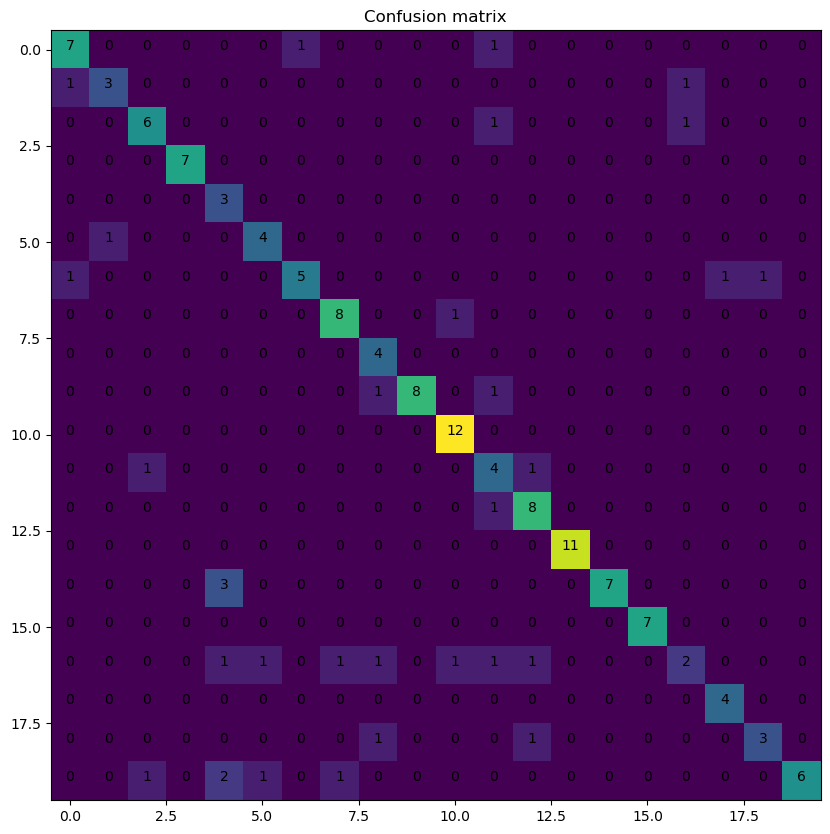

In [25]:
plt.figure(figsize=(10,10))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes4)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

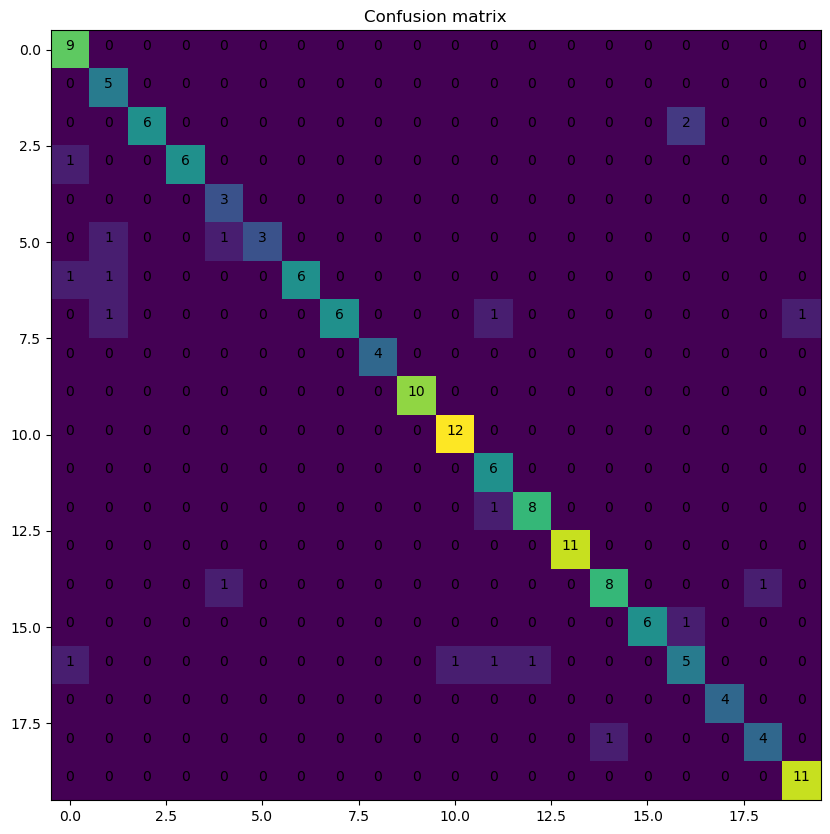

In [26]:
plt.figure(figsize=(10,10))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes5)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [27]:
predicted_classes4 = np.array(predicted_classes4)
predicted_classes5 = np.array(predicted_classes5)


In [39]:
def videoviewTest(index, predicted_classes):
    predicted_classes = predicted_classes
    fig = plt.figure(figsize=(32,8))
    for i,image in enumerate(x_test[index]):
        ax = plt.subplot(1,5,i+1)
        imshow(image[:,:,0])
        a=label_data.labels.values[y_test[index]+81]
        b=label_data.labels.values[predicted_classes[index]+81]
        plt.title(a,fontsize=27)
        if a==b:
            plt.xlabel(b,fontsize=27, color='green')
        else:
            plt.xlabel(b,fontsize=27, color='red')

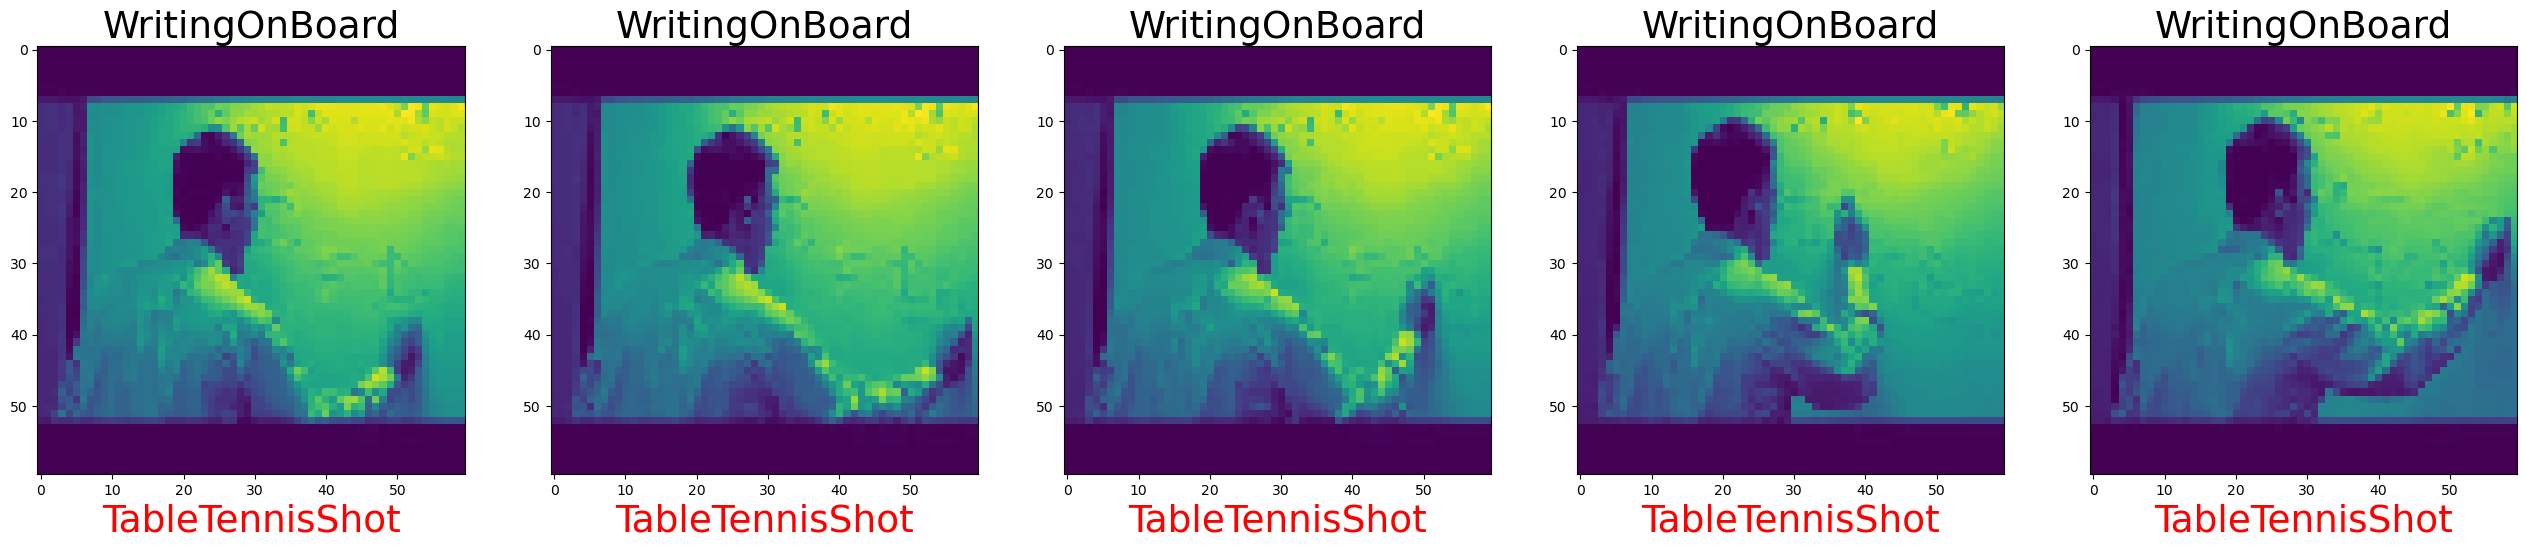

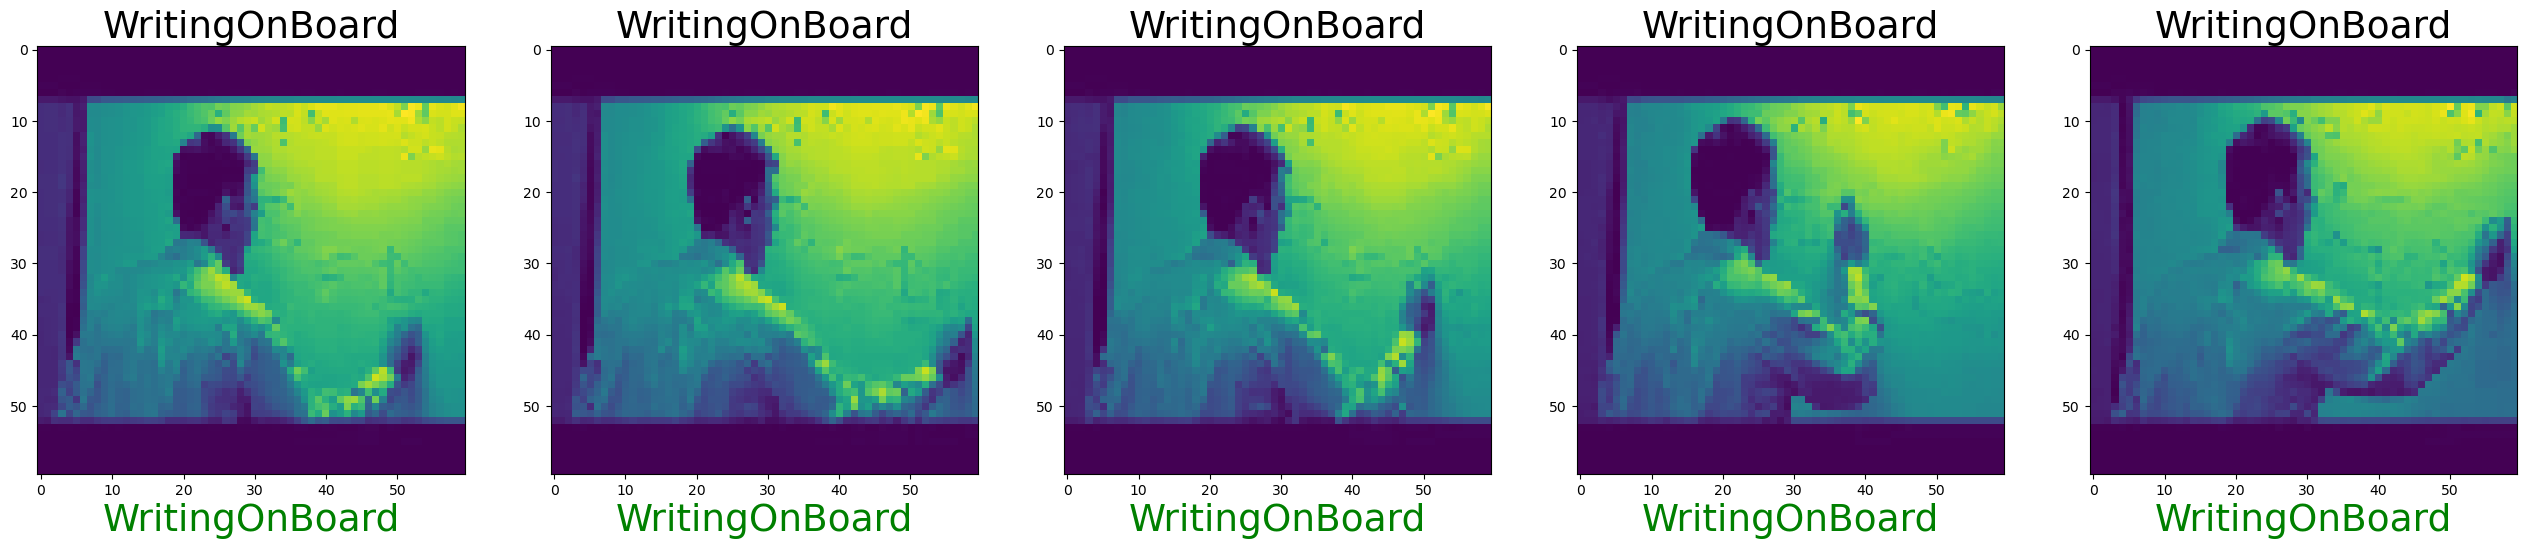

In [40]:
videoviewTest(60,predicted_classes4)
videoviewTest(60,predicted_classes5)

In [41]:
print(classification_report(y_test, predicted_classes4))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.75      0.60      0.67         5
           2       0.75      0.75      0.75         8
           3       1.00      1.00      1.00         7
           4       0.33      1.00      0.50         3
           5       0.67      0.80      0.73         5
           6       0.83      0.62      0.71         8
           7       0.80      0.89      0.84         9
           8       0.57      1.00      0.73         4
           9       1.00      0.80      0.89        10
          10       0.86      1.00      0.92        12
          11       0.44      0.67      0.53         6
          12       0.73      0.89      0.80         9
          13       1.00      1.00      1.00        11
          14       1.00      0.70      0.82        10
          15       1.00      1.00      1.00         7
          16       0.50      0.22      0.31         9
          17       0.80    

In [42]:
print(classification_report(y_test, predicted_classes5))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       0.62      1.00      0.77         5
           2       1.00      0.75      0.86         8
           3       1.00      0.86      0.92         7
           4       0.60      1.00      0.75         3
           5       1.00      0.60      0.75         5
           6       1.00      0.75      0.86         8
           7       1.00      0.67      0.80         9
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        10
          10       0.92      1.00      0.96        12
          11       0.67      1.00      0.80         6
          12       0.89      0.89      0.89         9
          13       1.00      1.00      1.00        11
          14       0.89      0.80      0.84        10
          15       1.00      0.86      0.92         7
          16       0.62      0.56      0.59         9
          17       1.00    